In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision as tv
from torchvision import transforms
from torch.autograd import Variable

from PIL import Image
import numpy as np

import json
import ast
import matplotlib.pyplot as plt

In [16]:
import warnings 

warnings.filterwarnings('ignore')

# 读取imagenet 所有的类别
with open('Imagenet_class_list.txt') as imagenet_classes_file:
    imagenet_classes_dict = ast.literal_eval(imagenet_classes_file.read())

# 根据Imagenet 做变换
tran=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

# 恢复图像
def deprocess(img):
    img[0,:,:] = img[0,:,:] * 0.229 + 0.485
    img[1,:,:] = img[1,:,:] * 0.224 + 0.456
    img[2,:,:] = img[2,:,:] * 0.225 + 0.406
    return img

def create_title(category, proba):
    return '"%s" %.1f%% confidence' % (category.replace('_', ' '), proba * 100)

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def generate_title(model, array):
    pred = vgg16(array)
    ind = int(np.argmax(pred.data[0]))
    label = imagenet_classes_dict[ind]
    prob = softmax(pred.data[0].numpy())
    
    return ind, label, prob[ind]

In [8]:
# G攻击模型
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Text(0.5,1,"(937, 'broccoli', 0.99295944)")

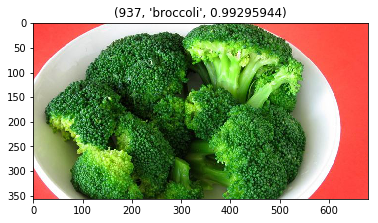

In [17]:
# 正常检测

filename = 'images/brocoli.jpg'
original_pic   = Image.open(filename)

img = tran(original_pic)
img.unsqueeze_(dim=0)

plt.imshow(original_pic)
plt.title(generate_title(vgg16, img))

# 生成对抗样本

In [18]:
def attack_example(model, img):
    sigma = 0.03
    
    pred = model(img)
    ind = pred.argmax()
    labels = ind.data.numpy().tolist()
    input_holder = Variable(img, requires_grad = True)
    out = model(input_holder)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(out, Variable(ind.view(1)))
    
    loss.backward()
    
    signs = torch.sign(input_holder.grad.data)
    
    input_holder.data = input_holder.data + sigma * signs
    
    return input_holder, signs

In [19]:
def restore_img(img_tensor):
    pro_img = img_tensor.data.numpy()
    pro_img = pro_img.copy()
    pro_img = pro_img.squeeze(0)
    pro_img = deprocess(pro_img)
    pro_img = pro_img.transpose(1,2,0)
    return pro_img

In [20]:
img_attack, perturbation = attack_example(vgg16, img)

In [21]:
# 攻击结果
print(generate_title(vgg16, img))
print(generate_title(vgg16, img_attack))
print(generate_title(vgg16, perturbation))

(937, 'broccoli', 0.99295944)
(938, 'cauliflower', 0.6342064)
(824, 'stole', 0.2801985)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,"(938, 'cauliflower', 0.6342064)")

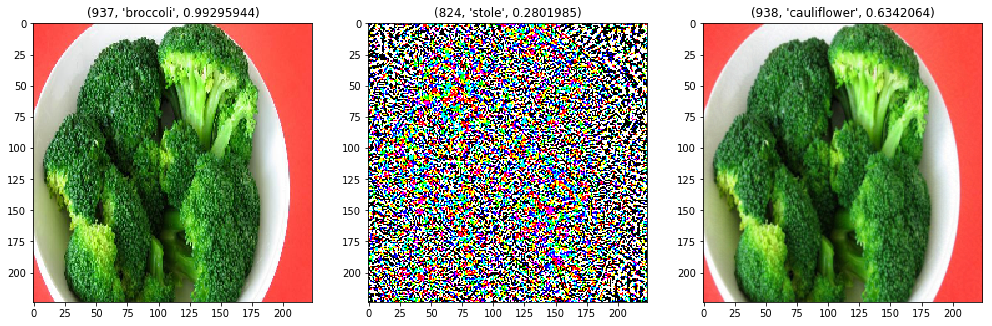

In [22]:
# 可视化
plt.figure(figsize = (17, 17))
plt.subplot(1,3,1)
plt.imshow(original_pic.resize((224,224)))
plt.title(generate_title(vgg16, img))

plt.subplot(1,3,2)
tmp = (perturbation.data.numpy().squeeze(0)).transpose(1,2,0)
plt.imshow(tmp)
plt.title(generate_title(vgg16, perturbation))

plt.subplot(1,3,3)
plt.imshow(restore_img(img_attack))
plt.title(generate_title(vgg16, img_attack))

NameError: name 'perturbation' is not defined